In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import IPython.display as Id
from ipywidgets import interact

from scipy.io import wavfile
import requests
from io import BytesIO
import os

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

    # The Sound of Harmonics - Approximating instruments with Fourier Series

In a previous article about the [Fourier Series calculation](http://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html) we have illustrated how different numbers of harmonics approximate artificial periodic functions. The present post applies the results to the analysis of instrument sounds, namely sounds of a saxophone. 

When playing a stationary tone on a saxophone, we hear a constant sound. Hence, we can assume its waveform is periodic, since we could start to listen to the tone at any time and would still hear the same tone. So, the waveform needs to repeat itself over and over again.  In this case, it should be possible to expand the waveform into sines and cosines of harmonic frequencies and reconstruct the original signal from them.

We want to verify this is assumption with this post. Let us start with functions to calculate the Fourier series, `fourierSeries` and for reconstructing a signal from its Fourier series coefficients, `reconstruct`.

In [6]:
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

In [7]:
def reconstruct(P, anbn):
    """Sum up sines and cosines according to the coefficients to 
    produce a reconstruction of the original waveform"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

First of all, let's load three sounds of saxophone sounds from the internet:

In [8]:
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:
        data = data[:, 0]
    return data, rate

save_dir = "../data/atividade_12/"
os.makedirs(save_dir, exist_ok=True)

# the URLs of the wav files
urls = ["http://cd.textfiles.com/sbsw/INSTRMNT/TENORSA.WAV"]
sounds = []
for i, url in enumerate(urls):
    sound, rate = loadSound(url)
    file_name = f"{save_dir}audio_{i}.wav"
    wavfile.write(file_name, rate, sound)
    print(f"Áudio salvo em: {file_name}")

Áudio salvo em: ../data/atividade_12/audio_0.wav


In [12]:
# Utility function two display two audios side by side in the notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '<table class="audiotable"><tr><td>%s</td><td>%s</td></tr><tr><td>%s</td><td>%s</td></tr></table>' % (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(Id.HTML(text))

Let's listen to the downloaded sounds of the played saxophone:

In [10]:
save_dir = "../data/atividade_12/"

# Obtendo a lista de arquivos de áudio na pasta
audio_files = [f for f in os.listdir(save_dir) if f.endswith('.wav')]

print(audio_files)

# Exibindo cada arquivo de áudio
Id.Audio('../data/atividade_12/audio_0.wav')

['audio_0.wav']


They are pretty different, but all clearly sounding like a saxophone. Let's look at the waveform of one sounds to see if its wave is indeed periodic:

In [11]:
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.figure(figsize=(8,4))
plt.subplot(211)
plt.plot(t, sounds[0][0])
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.subplot(212)
plt.plot(t, sounds[0][0])
plt.xlim((1, 1.05))
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.tight_layout()

IndexError: list index out of range

The upper figure shows the whole waveform. There, we can not see any large-scale periodicity. This is clear, since in the original sound we also can hear the start and end of the tone. Looking at the second figure, which shows a zoomed-in version, we can clearly see a very stable periodicity. So, we should be able to extract one period out of this signal and expand it into a Fourier series. Let's do this:

Original,Extracted period


Original,Extracted period


Original,Extracted period


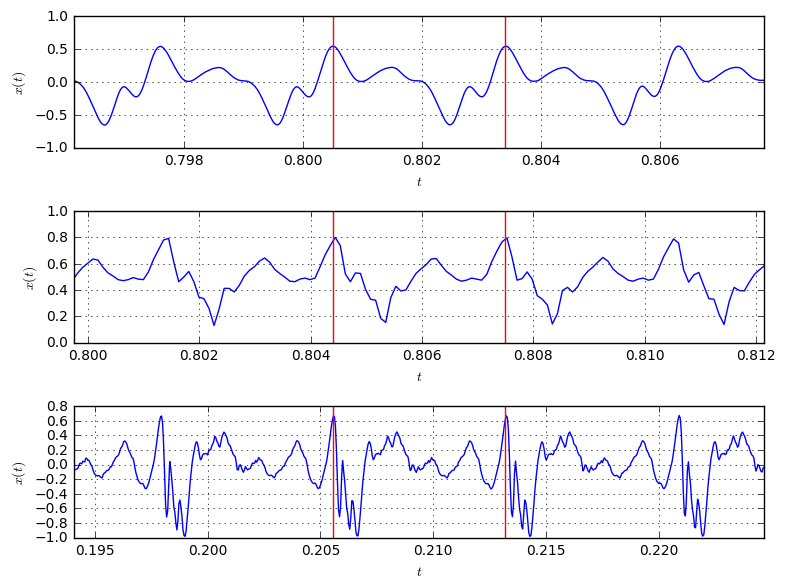

In [ ]:
def extractPeriod(data, rate, t_start, t_end):
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)

    duration = t_end - t_start
    plt.xlim((t_start-1.5*duration, t_end+1.5*duration))
    plt.grid(True)
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');

    plt.axvline(t_start, color='red')
    plt.axvline(t_end, color='red')

    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Original", Audio(data=data,rate=rate), 
                    "Extracted period", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

plt.figure(figsize=(8,6))
periods = []
rates = []
# The manually found start and end time of one period of the signal
periodBounds = [(0.8005,0.8034),
                (0.8044,0.8075),
                (0.20555,0.2132)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)
plt.tight_layout()

Here, we can hear the original sounds and the periodic repetition of one extracted period. We can hear a very close match between the two sounds. This confirms, that we can indeed use a single period of the wave to create a smooth instrument sound. In addition, we can explicitely see the periodicity of the signal by looking at the time-domain plots. The beginning and end of one period is marked in each figure. 

The first waveform looks most smooth, there are no inflections or quick jumps contained. Hence, we expect this waveform to contain the least harmonics, such that we can easily approximate it with very few sines and cosines. You can actually hear the smoothness of the waveform as a very soft tone. 

In contrast, the waveform of the last sound has very quick variations, leading to a crunchy sound. We can expect that we need lots of harmonics to accurately generate such a signal.

Let us write a function that takes one period of a signal, calculates is Fourier series and reconstructs the period up to the $N$th harmonic. In addition we show the power of each harmonic, where the power of the $n$th harmonic is calculated as $P_n=\sqrt{a_n^2+b_n^2}$. 

In [ ]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    
    plt.figure(figsize=(8,2))
    plt.subplot(121)
    plt.plot(t*1000, period, label='Original') 
    plt.plot(t*1000, reconstructed, label='Reconstructed')
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t)$'); plt.grid(True)
    plt.subplot(122)
    powers[0]=0
    plt.stem(powers)
    plt.xlim((0,20))
    plt.ylabel('Harmonic power'); plt.xlabel('Harmonic index'); plt.grid(True)
    plt.tight_layout()
    
    audioSideBySide("Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Reconstructed up to %d harmonics" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

Let's listen to the original sounds and their reconstruction with only a single harmonic (we do not consider the zero-frequency cosine to be a harmonic, as it is just a constant signal):

Original,Reconstructed up to 1 harmonics


Original,Reconstructed up to 1 harmonics


Original,Reconstructed up to 1 harmonics


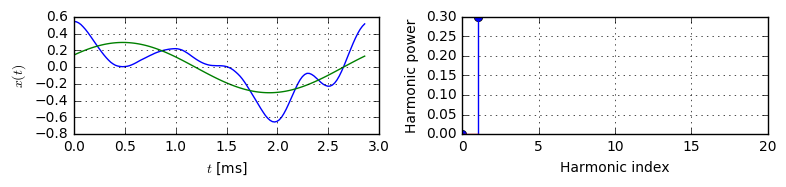

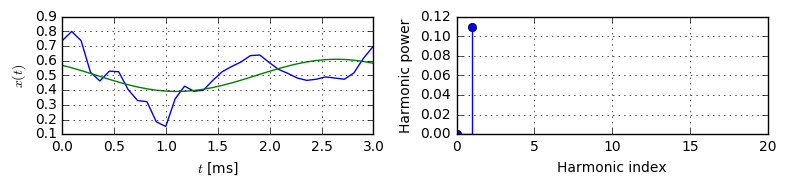

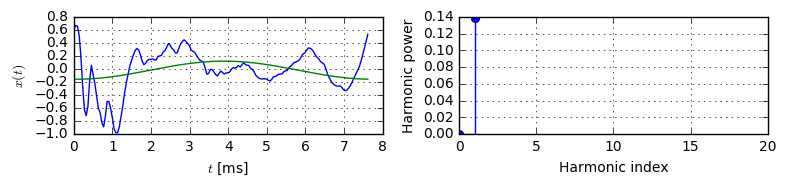

In [ ]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

Looking at the waveforms with just a single harmonic we cannot accurately reconstruct the original signal. Accordingly, the approximate sound is very different from the original. In fact, the reconstructed signals are pure sine wave. So, in case you did not know, how a pure sine sounds, you can do it now.

Let's allow the signal to be reconstructed from 2 harmonics:

Original,Reconstructed up to 2 harmonics


Original,Reconstructed up to 2 harmonics


Original,Reconstructed up to 2 harmonics


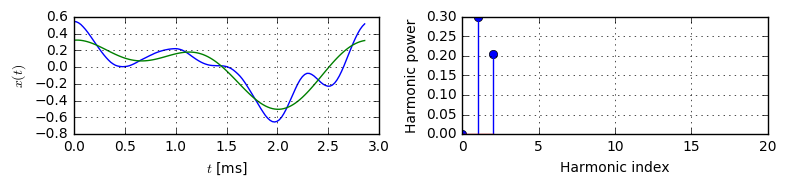

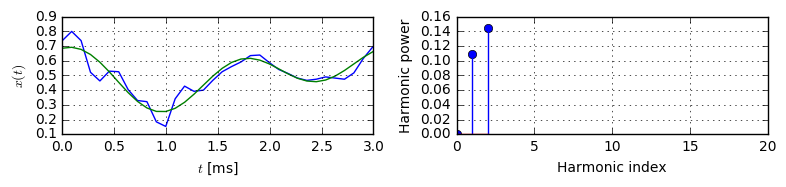

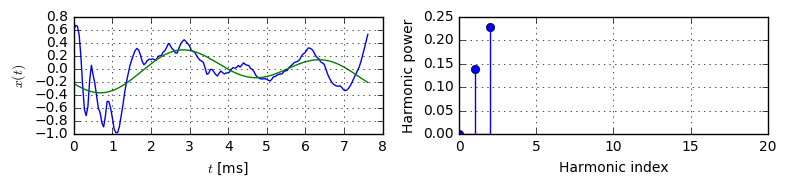

In [ ]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

We can see that the waveforms already have a similar shape, but the details are still missing. In particular, the strong oscillations of the third waveform are not well covered. The sounds already gains more character and similarity to the original signal, but the fine details are also missing in the sounds.

Let's go on and allow 5 harmonics for the reconstruction:

Original,Reconstructed up to 5 harmonics


Original,Reconstructed up to 5 harmonics


Original,Reconstructed up to 5 harmonics


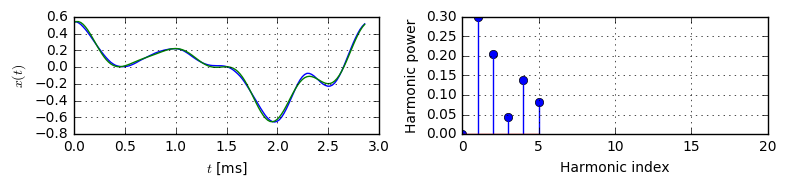

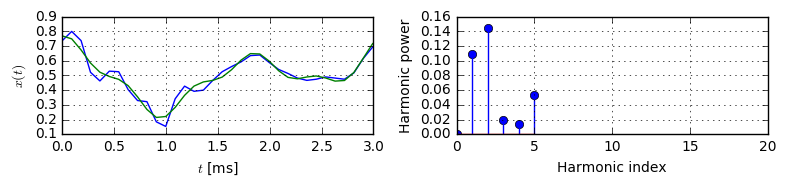

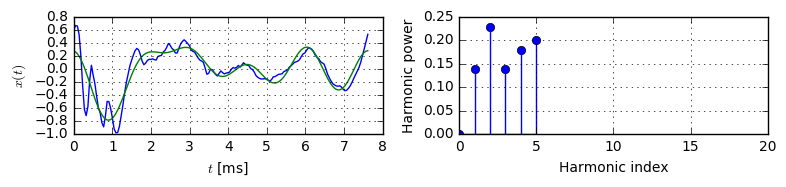

In [ ]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 5)

We see, that the first waveform is already quite accurately reconstructed. Hence, the sounds of the reconstructed signal is very similar to the original sound. However, for the 2nd and 3rd signal, the sound is still kind of "soft" compared to the more crunchy character of the original sound. We can confirm this is the time-domain plots, as the details of the waveforms are still not accurately reproduced.

Let's go on and try more harmonics.

Original,Reconstructed up to 10 harmonics


Original,Reconstructed up to 10 harmonics


Original,Reconstructed up to 10 harmonics


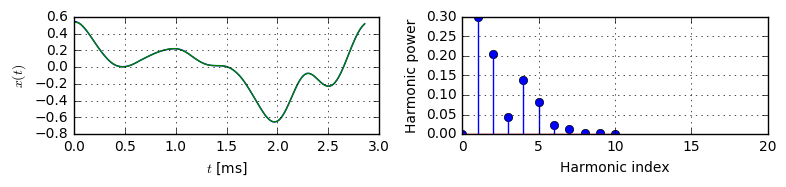

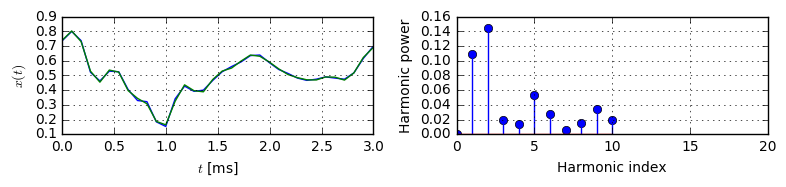

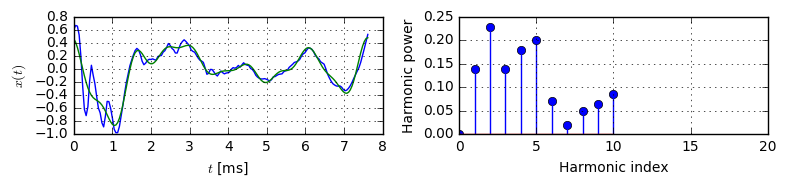

In [ ]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

Since the first sound was already described very well with 5 harmonics, the powers of the higher harmonics are now very small, since these are not needed to describe the original signal. In contrast, for the 2nd and 3rd signal, there are still significant contributions from the higher frequencies to the original signal. We can now see, that also the 2nd signal was well reproduced, and also the sound of the reconstructed signal is close to the original signal. Only, for the 3rd signal, the reconstructed sound is still too "soft" compared to the original. In particular we can see, that the Fourier series still cannot follow the fast oscillations in the beginning of the signal. So, we can try more harmonics for this signal:

Original,Reconstructed up to 20 harmonics


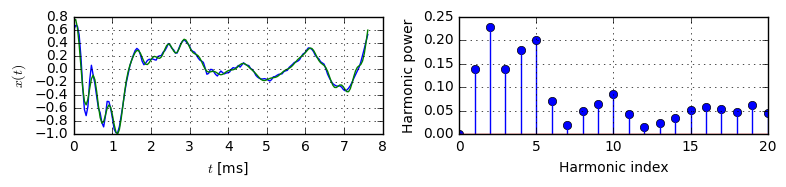

In [ ]:
for P, R in list(zip(periods, rates))[2:]:
    approximateUpToNthHarmonic(P, R, 20)

Eventually, the reconstruction manages to do the small oscillations in the beginning of the period. However, it is still not accurate and the sound is still a bit too smooth. Looking at the power of the different harmonics, we see that all higher frequencies have a significant contribution, so it appears we need more harmonics to reproduce this signal:

Original,Reconstructed up to 30 harmonics


Original,Reconstructed up to 40 harmonics


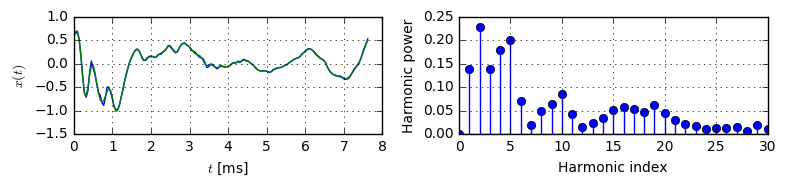

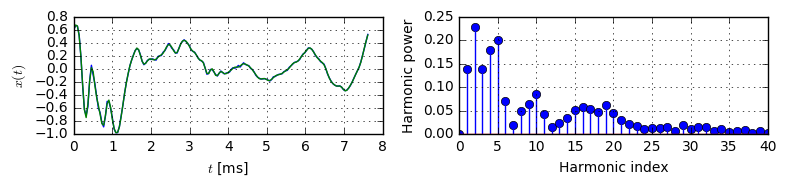

In [ ]:
for P, R in list(zip(periods, rates))[2:]:
    approximateUpToNthHarmonic(P, R, 30)
    plt.xlim(0,30)
    approximateUpToNthHarmonic(P, R, 40)
    plt.xlim(0,40)

Finally, when using 40 harmonics, we could create a similar waveform and sound. Did you expect that we would need so many harmonics? Let's discuss in the comments!

Let us eventually look at the most serious challenge: Reconstructing a square wave by the Fourier series. In the previous post about the Fourier series, we have seen a significant amount [overshooting and Gibbs Phenonenom](http://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html) when trying to approximate the non-continuous square wave with sums of smooth sines and cosines. Let's first generate a square wave and listen how it sounds:

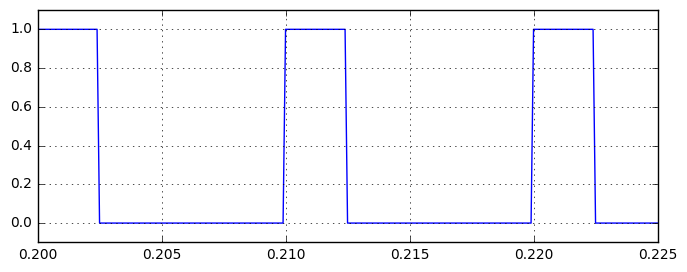

In [ ]:
Fs = 10000
F = 100
N = Fs/F
T=1
period = (np.arange(N) < (N/4)).astype(float)
t = np.arange(0, T, 1/Fs)
signal = np.tile(period, T*F)
plt.plot(t, signal)
plt.xlim((0.2, 0.225)); plt.ylim((-0.1, 1.1)); plt.grid(True)
Audio(data=signal, rate=Fs)

Well, sounds a bit like the noise which occurs when you touch the audio cable of your stereo... In any case, you can already hear that it contains both very low and high frequencies. Let's analyze it with the Fourier series of different order:

Original,Reconstructed up to 1 harmonics


Original,Reconstructed up to 3 harmonics


Original,Reconstructed up to 5 harmonics


Original,Reconstructed up to 11 harmonics


Original,Reconstructed up to 21 harmonics


Original,Reconstructed up to 49 harmonics


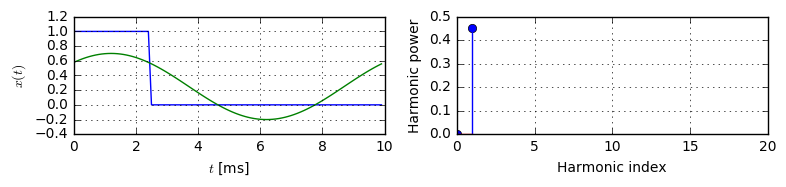

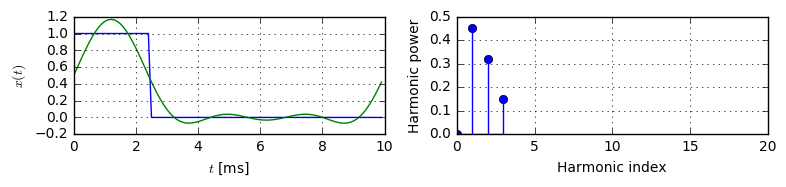

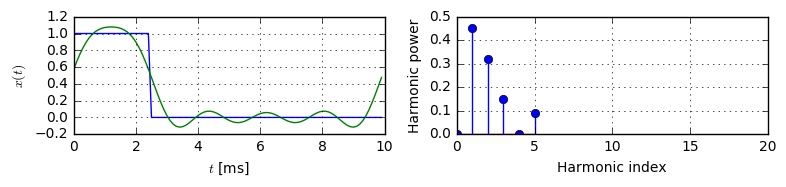

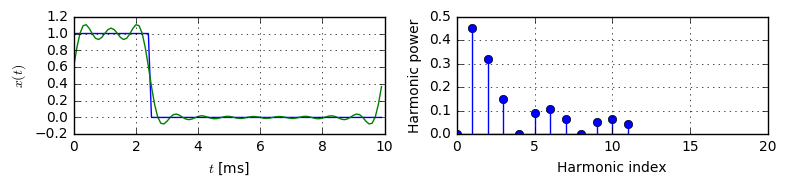

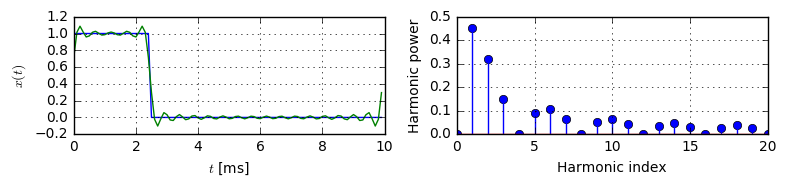

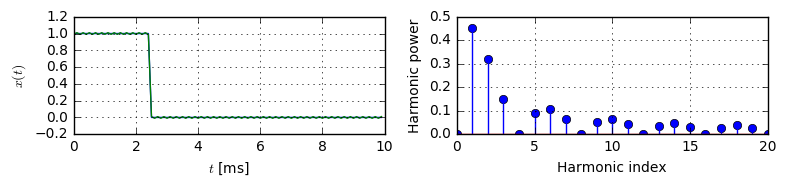

In [ ]:
for N in [1, 3, 5, 11, 21, 49]:
    approximateUpToNthHarmonic(period, Fs, N)

As we have expected, we need a lot of harmonics to accurately recreate the waveform of the signal. In particular, we see a common pattern in the power of the harmonics: There's a zero every 4th harmonic, and in between there are bumps that decay with higher order. Especially, it reminds of a sinc-function where the zeros have a distance of 4 units. This is not just by coincidence. Instead, we know that the Fourier transform of a rectangular of width 1/4 is a sinc functions where the zeros are 4 units apart. Hence, we again see a strong relationship between the Fourier series and the Fourier transform. In a future article, we will analyze this relation in more detail. Subscribe to the newsletter to stay informed!

## Summary
> - The Fourier Series expands a periodic signal into a sum of harmonic frequencies.
> - Tones from an instrument are periodic signals, which can hence be analyzed with the Fourier series.
> - "Soft" sounds can be described with less harmonics than more "crunchy" sounds. Hence, the "crunchyness" of a sound stems from high-frequency harmonics.